In [89]:
import torch
import sys
sys.path.extend(['..'])
from mvn import MVNIso, create_mog, MVNFull
from distributions import log_prob_mix_laplace as log_p
from util import acf, ess, estimate_log_z
from math import log, pi, sqrt, exp
import matplotlib.pyplot as plt
import time
from tqdm.notebook import trange
import numpy as np
from scipy.integrate import quad
from samplers.mcmc import HMC
from pathlib import Path
%matplotlib inline
import numpy as np
sd = 2479108
torch.manual_seed(sd)
np.random.seed(sd)

## 2d examples

In [2]:
### Or choose cigar!!
from distributions import log_prob_banana as log_p

x = torch.linspace(-4, 4, 201)
xx, yy = torch.meshgrid(x, x)
xy = torch.stack([xx.flatten(), yy.flatten()], dim=0)
log_p_grid = log_p(xy)
p_grid = (log_p_grid - torch.logsumexp(log_p_grid.flatten(), dim=0)).exp().reshape(xx.size())

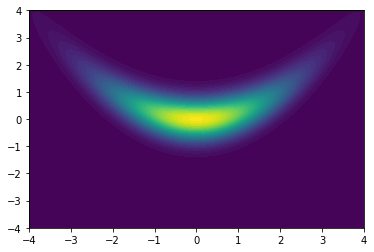

In [3]:
plt.contourf(xx, yy, p_grid, origin='lower', vmin=0., levels=50)

### Define a 2d polynomial

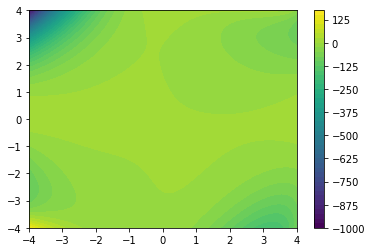

In [4]:
n=10
random_coeffs = torch.randn(n,n)
f = torch.Tensor([[np.math.factorial(n) for n in range(10)]])
nicer_coeffs = random_coeffs/f/f.T

def random_poly(xy):
    """Basically np.polynomial.polynomial.polyval2d in pytorch.
    xy can be a (2,n) tensor"""
    if xy.size(0) == 2:
        x, y = xy[0], xy[1]
    else:
        x, y = xy[:, 0], xy[:, 1]
        
    terms = sum([[nicer_coeffs[i,j] * x**i * y**j for i in range(nicer_coeffs.size(0))]
                                                   for j in range(nicer_coeffs.size(1))], [])
    return torch.stack(terms, dim=0).sum(0) 
        
poly_grid = random_poly(torch.stack((xx,yy)))
plt.contourf(xx, yy, poly_grid, origin='lower', levels=50)
plt.colorbar()

## Get ground truth

In [5]:
from scipy.integrate import dblquad

In [6]:
def integrand(x,y):
    xy = torch.Tensor([x, y])
    return random_poly(xy) * log_p(torch.Tensor(xy))
random_poly_expectation = dblquad(integrand, -10, 10, lambda x: -5, lambda x: 5)
random_poly_expectation

### Compute expectation under variational sol'n

Text(0, 0.5, 'KL(q||p) + log Z')

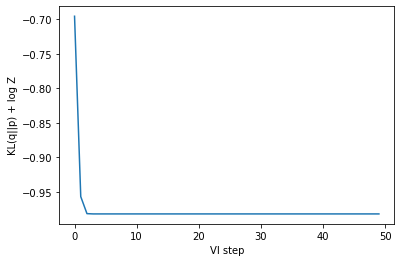

In [38]:
q_vi = MVNIso.new_random(d=2)
q_vi.theta.requires_grad_(True)

def _kl_q_p_helper():
    kl = -q_vi.entropy() - q_vi.quadrature_ev(log_p, 5)
    grad_kl = torch.autograd.grad(kl, q_vi.theta, create_graph=True)[0]
    hess = torch.zeros(q_vi.n_params, q_vi.n_params)
    for i in range(q_vi.n_params):
        hess[i, :] = torch.autograd.grad(grad_kl[i], q_vi.theta, retain_graph=True)[0]
    return kl.detach(), grad_kl.detach(), hess

kl_vals = torch.zeros(50)
for i in range(50):
    kl_vals[i], grad, hess = _kl_q_p_helper()
    with torch.no_grad():
        # Newton's method step
        q_vi.theta.copy_(q_vi.theta - torch.linalg.solve(hess, grad))
q_vi.theta.requires_grad_(False)

plt.figure()
plt.plot(kl_vals)
plt.xlabel('VI step')
plt.ylabel('KL(q||p) + log Z')

tensor(1.3515)


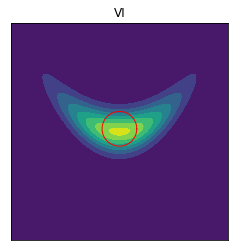

In [39]:
q_vi_expectation = q_vi.quadrature_ev(random_poly, 10)

plt.contourf(xx, yy, p_grid, origin='lower', vmin=0.)
plt.title('VI')
plt.xticks([]); 
plt.yticks([])
plt.axis('image')
plt.plot(*q_vi.ellipse(nsigma=1.), color='r', linewidth=1)
print(q_vi_expectation)

## Do HMC sampling with various $\lambda$

In [57]:
def log_psi(lam, q):
    kl_qp = -q.entropy() - q.quadrature_ev(log_p, n=25)
    return 0.5*q.log_det_fisher() - lam * kl_qp

def sample_theta(lam, n=1000):
    q = MVNIso(d=2)
    hmc = HMC(lambda th: log_psi(lam, q.set_theta(th)), leapfrog_t=2.)
    hmc.tune(torch.randn(200, q.n_params), target_accept=0.95)

    print(f"[lam={lam}]\tmass={hmc.mass.numpy()}\tdt={hmc.dt.item():.4f}")
    return hmc.sample(torch.randn(q.n_params), n, progbar=True)

### Run a long sampling chain once per $\lambda$

In [ ]:
#compute 
lambdas = torch.logspace(0,2,10)
hmc_results = []
for l in lambdas:
    save_file = Path('results') / f"{log_p.__name__}_hmc_lam={l:.3f}.dat"
    if save_file.exists():
        res = torch.load(save_file)
    else:
        res = sample_theta(l, n=10000)
        torch.save(res, save_file)
    hmc_results.append(res)
    print(f"\tfinished lam={l:.3f}, ESS={ess(res['samples']).numpy()}")

	finished lam=1.000, ESS=[11.478797  41.15552    2.7337232]
[lam=1.6681005954742432]	mass=[0.31922   0.2969289 1.4078668]	dt=0.0704


HMC.sample [93.5]:  14%|████████████▊                                                                               | 1405/10100 [41:07<8:41:13,  3.60s/it]

In [ ]:
# or load from file
lambdas = torch.logspace(0,2,10)
hmc_results = []
for l in lambdas:
    save_file = Path('results') / f"{log_p.__name__}_hmc_lam={l:.3f}.dat"
    hmc_results.append(torch.load(save_file))

### Calculate 'asymptotic' bias by computing expected value random polynomial for every value of the chain

In [ ]:
q = MVNIso(d=2)
full_chain_expectations = torch.zeros(len(lambdas))
for i, r in enumerate(hmc_results):
    component_evs = [q.set_theta(th).quadrature_ev(random_poly, n=10) for th in r['samples']]
    full_chain_expectations[i] = torch.tensor(component_evs).mean()

### Calculate variance by subsampling each chain down to 100 samples many times

In [ ]:
n_subsample, n_run = 100, 50
q = MVNIso(d=2)
subsample_expectations = torch.zeros(len(lambdas), n_run)
for i, r in enumerate(hmc_results):
    for j in range(n_run):
        subset_samples = r['samples'][torch.randint(r['samples'].size(0), (n_subsample,)), :]
        component_evs = [q.set_theta(th).quadrature_ev(random_poly, n=10) for th in r['samples']]
        subsample_expectations[i, j] = torch.tensor(component_evs).mean()

est_variance = torch.mean((subsample_expectations - full_chain_expectations[:, None])**2)

### Plot EVs

In [ ]:
plt.semilogx(lambdas, full_chain_expectations, '-o')
plt.hlines(random_poly_expectation, 1,100,color='r')
plt.hlines(q_vi_expectation, 1,100,color='k')
plt.xlabel("$\lambda$");
plt.ylabel("EV")
plt.legend(['$m_\lambda(x)$', 'true value', 'VI EV')
plt.show()

### Plot bias$^2$ and variance

In [ ]:
bias2 = (full_chain_expectations - random_poly_expectation)**2
mse = bias2 + est_variance

plt.semilogx(lambdas, bias2, '-b', marker='.')
plt.semilogx(lambdas, est_variance, '-r', marker='.')
plt.semilogx(lambdas, mse, '-g', marker='.')
plt.xlabel("$\lambda$");
plt.legend(['bias$^2$', 'variance', 'MSE'])
plt.show()